In [1]:
import uproot
import uproot_methods
import numpy as np
import pandas as pd


In [51]:
f = uproot.open('/data/hnl/KShort/ntuples/dijet_mc16e/JZ8/user.rnewhous.23060122._000052.tree.root')
outTree = f['outTree']
df = outTree.pandas.df(flatten=False, entrystop=100)
outTree.keys()

24000

# Control Region
This is a mehod that calculates whether or not there is a prompt lepton in the event. This is the definition of our control region so we are not accidentally plotting potential signal regions.

In [2]:
def calc_pass_cr(row):
    '''To be used with df.apply()'''
    # Check muons
    for loose, medium, tight, d0, z0sintheta in zip(row['muon_isLoose'], 
                                                    row['muon_isMedium'], 
                                                    row['muon_isTight'],
                                                    row['muon_trkd0'],
                                                    row['muon_trkz0sintheta'],
                                   ):
        if loose or medium or tight:
            if abs(d0) < 3.0 or abs(z0sintheta) < 0.5: #mm
                return 0 # Found a prompt muon. Does not pass CR.
    # Check electrons
    for loose, medium, tight, d0, z0sintheta in zip(row['el_LHLoose'], 
                                                    row['el_LHMedium'], 
                                                    row['el_LHTight'],
                                                    row['el_trkd0'],
                                                    row['el_trkz0sintheta'],
                                   ):
        if loose or medium or tight:
            if abs(d0) < 3.0 or abs(z0sintheta) < 0.5: #mm
                return 0 # Found a prompt electron. Does not pass CR.
    return 1

# Alpha
This is the calculation of the parameter alpha, which is used to reduce the background when selecting k-short vertices.

In [3]:
def calc_alpha(row):
    '''To be used with df.apply()'''
    alphas = []
    
    if len(row['secVtx_VSI_LRTR3_1p0_x']) == 0:
        return alphas
    
    # primary vertex position vector
    pv_vector = uproot_methods.TVector3(row['vertex_x'],
                                        row['vertex_y'],
                                        row['vertex_z'])    

    for dv_x, dv_y, dv_z, dv_phi in zip(row['secVtx_VSI_LRTR3_1p0_x'], 
                                        row['secVtx_VSI_LRTR3_1p0_y'], 
                                        row['secVtx_VSI_LRTR3_1p0_z'],
                                        row['secVtx_VSI_LRTR3_1p0_phi'],
                                       ):

        # secondary vertex position vector
        sv_vector = uproot_methods.TVector3(dv_x,
                                            dv_y,
                                            dv_z)

        # vector from pv to sv
        pv_sv_vector = sv_vector - pv_vector

        # vector difference between momentum vector and position vector
        alpha = pv_sv_vector.phi - dv_phi
        # put in -pi to pi range
        alpha = (alpha + np.pi/2) % np.pi*2 - np.pi
        alphas.append(alpha)
    return alphas

# Iterating over a set of files
Using this method, we will iterate over several trees chained together across files. Uproot has some good documentation on how this works. https://uproot.readthedocs.io/en/latest/opening-files.html#uproot-iterate

In [110]:
    
vertex_branches = ['secVtx_VSI_LRTR3_1p0_mass',
                    'secVtx_VSI_LRTR3_1p0_ntrk',
                    'secVtx_VSI_LRTR3_1p0_ntrk_lrt',
                    'secVtx_VSI_LRTR3_1p0_trk_isLRT',
                    'secVtx_VSI_LRTR3_1p0_r',
                    'secVtx_VSI_LRTR3_1p0_pt',
                    'secVtx_VSI_LRTR3_1p0_eta',
                    'secVtx_VSI_LRTR3_1p0_x',
                    'secVtx_VSI_LRTR3_1p0_y',
                    'secVtx_VSI_LRTR3_1p0_z',
                    'secVtx_VSI_LRTR3_1p0_phi',]

lepton_branches = ['muon_isTight',
                    'muon_isMedium',
                    'muon_isLoose',
                    'muon_trkd0',
                    'muon_trkz0sintheta',
                    'el_LHTight',
                    'el_LHMedium',
                    'el_LHLoose',
                    'el_trkd0',
                    'el_trkz0sintheta',]

pv_branches = ['vertex_x',
                'vertex_y',
                'vertex_z',]

branches = vertex_branches + lepton_branches + pv_branches

# remove duplicates
branches = list(dict.fromkeys(branches))


full_df = None

# for it in uproot.tree.iterate('/data/hnl/KShort/ntuples/dijet_mc16e/JZ8/*', 
for it in uproot.tree.iterate('/data/hnl/KShort/ntuples/dijet_mc16e/JZ12/*/submitDir/data-tree/files.root', 
                             'outTree',
                            branches=branches,
                            ):    

    # load chunk into dataframe
    df = pd.DataFrame(it)
    # remove bytesteam flag from columns
    df.columns = branches

    # calculate variables needed in selection
    
    # cut on control region
    df['pass_cr'] = df.apply(calc_pass_cr, axis=1)
    df = df.query('pass_cr > 0')
    # cut on number of DVs
    df = df[df['secVtx_VSI_LRTR3_1p0_mass'].str.len() > 1]
    # calculate alpha
    df['alpha'] = df.apply(calc_alpha, axis=1)
    
    # explode into a dataframe of just vertex quantities
    vtx_df = df[vertex_branches+['alpha']].apply(pd.Series.explode)
    
    # only use 2-trk vertices
    vtx_df = vtx_df.query('secVtx_VSI_LRTR3_1p0_ntrk == 2')
    
    # cut on alpha
    vtx_df = vtx_df[abs(vtx_df['alpha']) < 0.01]

    # append to the full dataframe
    if full_df is None:
        full_df = vtx_df
    else:
        full_df = full_df.append(vtx_df)
    print("Total vertices loaded:", len(full_df))
    
print("Finished")

Total vertices loaded: 9
Total vertices loaded: 40
Total vertices loaded: 72
Total vertices loaded: 77
Total vertices loaded: 88
Total vertices loaded: 95
Total vertices loaded: 97
Total vertices loaded: 110
Total vertices loaded: 115
Total vertices loaded: 125
Total vertices loaded: 137
Total vertices loaded: 146
Total vertices loaded: 161
Total vertices loaded: 166
Total vertices loaded: 181
Total vertices loaded: 189
Total vertices loaded: 193
Total vertices loaded: 208
Total vertices loaded: 219
Total vertices loaded: 228
Total vertices loaded: 239
Total vertices loaded: 250
Total vertices loaded: 261
Total vertices loaded: 273
Total vertices loaded: 277
Total vertices loaded: 288
Total vertices loaded: 293
Total vertices loaded: 307
Total vertices loaded: 315
Total vertices loaded: 324
Total vertices loaded: 333
Total vertices loaded: 338
Total vertices loaded: 350
Total vertices loaded: 363
Total vertices loaded: 389
Total vertices loaded: 402
Total vertices loaded: 408
Total ver

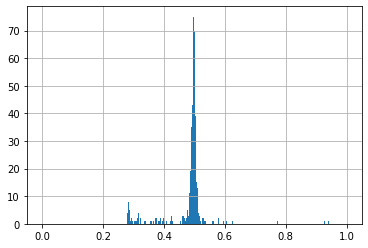

In [119]:
full_df.secVtx_VSI_LRTR3_1p0_mass.hist(bins=np.linspace(0,1,500))

In [8]:
# pd.read_pickle('/tmp/newhouse/jz12.pkl')


df = pd.concat([
    pd.read_pickle('/data/hnl/KShort/ntuples/dijet_mc16e/JZ12/output.pkl'),
    pd.read_pickle('/data/hnl/KShort/ntuples/dijet_mc16e/JZ11/output.pkl'),
    pd.read_pickle('/data/hnl/KShort/ntuples/dijet_mc16e/JZ10/output.pkl'),
    pd.read_pickle('/data/hnl/KShort/ntuples/dijet_mc16e/JZ8/output.pkl'),
    pd.read_pickle('/data/hnl/KShort/ntuples/dijet_mc16e/JZ9/output.pkl'),
])
    

<AxesSubplot:>

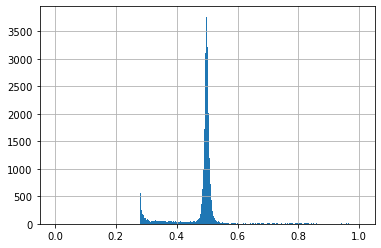

In [9]:
df.secVtx_VSI_LRTR3_1p0_mass.hist(bins=np.linspace(0,1,1000))

### Small snippet for merging multiple output MC files

In [4]:
import glob
import pandas as pd
jzslice = 'JZ2'
df = pd.concat([pd.read_pickle(path) for path in glob.glob(f'/data/hnl/KShort/ntuples/dijet_mc16e/{jzslice}_selected/*.pkl')])
df.to_pickle(f'/data/hnl/KShort/ntuples/dijet_mc16e/{jzslice}/output.pkl')



<AxesSubplot:>

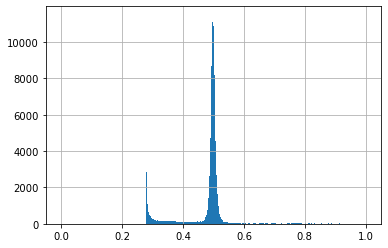

In [25]:
df.secVtx_VSI_LRTR3_1p0_mass.hist(bins=np.linspace(0,1,1000))